# Sparkify Churn Prediction

In [1]:
import findspark
findspark.init()

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [2]:
spark = SparkSession.\
    builder.\
    appName("Sparkify Churn Prediction").\
    getOrCreate()

22/09/17 14:32:31 WARN Utils: Your hostname, iusztin-MS-7C91 resolves to a loopback address: 127.0.1.1; using 192.168.0.170 instead (on interface enp42s0)
22/09/17 14:32:31 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/09/17 14:32:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Load and Clean Dataset

In [3]:
EVENT_DATA_LINK = "mini_sparkify_event_data.json"
df = spark.read.json(EVENT_DATA_LINK)
df.persist()

df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



We can observe that all the columns are `strings` or `longs`.

In [4]:
df.show(n=10)

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

## Check for Empty Values

### Check for NaNs

In [5]:
df.select([F.count(F.when(F.isnan(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



There are no `nans` within the data.

### Check for Nones

In [6]:
df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



Instead of `nans` the missing entries are filled with `Nones`.

### Check for Empty Strings

In [7]:
df.select([F.count(F.when(F.col(c) == "", c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|  8346|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [8]:
df.filter(F.col("userId") != "").select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [9]:
df.filter(F.col("userId") != "").select("auth").groupby("auth").count().show()

+---------+------+
|     auth| count|
+---------+------+
|Cancelled|    52|
|Logged In|278102|
+---------+------+



We can observe that some `users` have the `id` as an `empty string`. The number of open user ids, `8346`, equals the number of None properties, such as: `firstName`, `lastName`, `registration`, `userAgent`. Also, those events have the `auth` state `Cancelled` or `Logged In`. This means that the users who do not have an ID are those who `haven't registered`, yet, into the platform.

When the `artist`, `song`, and `length` columns are `None`, the user stays on pages that do not include listening to music.

## Check for Other Unwanted Symbols

In [10]:
df.select([F.count(F.when(F.col(c) == "-", c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [11]:
df.select([F.count(F.when(F.col(c) == "NaN", c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [12]:
df.select([F.count(F.when(F.col(c) == "None", c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



None of those symbols can be found within the dataset.

In [13]:
df.select([F.count(F.when(F.col(c).cast("int").isNull(), c)).alias(c) for c in df.columns]).show()

+------+------+---------+------+-------------+--------+------+------+--------+------+------+------------+---------+------+------+---+---------+------+
|artist|  auth|firstName|gender|itemInSession|lastName|length| level|location|method|  page|registration|sessionId|  song|status| ts|userAgent|userId|
+------+------+---------+------+-------------+--------+------+------+--------+------+------+------------+---------+------+------+---+---------+------+
|286277|286500|   286500|286500|            0|  286500| 58392|286500|  286500|286500|286500|        8346|        0|286110|     0|  0|   286500|  8346|
+------+------+---------+------+-------------+--------+------+------+--------+------+------+------------+---------+------+------+---+---------+------+



There are no `sessionIds` that couldn't be cast to an int type.

## Unregistered Users

### Check Unregistered Users Page Distribution

In [14]:
df.filter(F.col("userId") == "").select("page").groupby("page").count().show()

+-------------------+-----+
|               page|count|
+-------------------+-----+
|               Home| 4375|
|              About|  429|
|              Login| 3241|
|               Help|  272|
|              Error|    6|
|           Register|   18|
|Submit Registration|    5|
+-------------------+-----+



Because there is no valuable activity for churn prediction performed by empty users, we can drop them out of the DataFrame.

## Drop Unregistered Users

In [15]:
cleaned_df = df.filter(F.col("userId") != "")
cleaned_df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



## Empty Artists

### Check Empty Artists Distribution

In [16]:
df.filter(F.isnull(F.col("artist"))).select(["artist", "song", "userId", "page"]).show()

+------+----+------+---------------+
|artist|song|userId|           page|
+------+----+------+---------------+
|  null|null|    30|Add to Playlist|
|  null|null|     9|    Roll Advert|
|  null|null|     9|      Thumbs Up|
|  null|null|    54|      Downgrade|
|  null|null|    54|      Thumbs Up|
|  null|null|     9|    Thumbs Down|
|  null|null|     9|           Home|
|  null|null|     9|         Logout|
|  null|null|    74|      Thumbs Up|
|  null|null|      |           Home|
|  null|null|      |           Help|
|  null|null|      |           Home|
|  null|null|      |          Login|
|  null|null|     9|           Home|
|  null|null|    30|    Thumbs Down|
|  null|null|     4|         Logout|
|  null|null|      |           Home|
|  null|null|      |          Login|
|  null|null|     4|           Home|
|  null|null|    74|Add to Playlist|
+------+----+------+---------------+
only showing top 20 rows



In [17]:
df.filter(F.isnull(F.col("artist"))).select(["artist", "song", "userId", "page"]).groupby("page").count().show()

+--------------------+-----+
|                page|count|
+--------------------+-----+
|              Cancel|   52|
|    Submit Downgrade|   63|
|         Thumbs Down| 2546|
|                Home|14457|
|           Downgrade| 2055|
|         Roll Advert| 3933|
|              Logout| 3226|
|       Save Settings|  310|
|Cancellation Conf...|   52|
|               About|  924|
|            Settings| 1514|
|               Login| 3241|
|     Add to Playlist| 6526|
|          Add Friend| 4277|
|           Thumbs Up|12551|
|                Help| 1726|
|             Upgrade|  499|
|               Error|  258|
|      Submit Upgrade|  159|
|            Register|   18|
+--------------------+-----+
only showing top 20 rows



We can observe that when the artist is null, the users spend time on different pages than actually listening to music. In this case, such information is valuable for understanding the behavior of registered users.

### Impute empty values

In [18]:
# Fill the length of the song with 0.
# Fill the artist and the song with a string constant to signal that those pages don't have such information.
cleaned_df = cleaned_df.fillna({
    "length": 0,
    "artist": "unknown",
    "song": "unknown"
})
cleaned_df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



Great! Now our data no longer has any `None` values. The last cleaning step is to check the types of the variables.

## Check Types

In [19]:
cleaned_df.printSchema()

root
 |-- artist: string (nullable = false)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = false)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = false)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [20]:
cleaned_df.show(n=5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

All the types are looking all right. We can proceed to EDA.

# Exploratory Data Analysis

### Define Churn

We will consider that a user is `churn` when the subscription is canceled.

In [21]:
cleaned_df.select(F.count(F.when(F.col("page") == "Cancellation Confirmation", "page")).alias("Cancellation Confirmation")).show()

+-------------------------+
|Cancellation Confirmation|
+-------------------------+
|                       52|
+-------------------------+



In [22]:
# First, create the churn event based on the visited page.
# The churnEvent will be different for every event/visited page.
labeled_df = cleaned_df.withColumn("churnEvent", F.when(F.col("page") == "Cancellation Confirmation", 1).otherwise(0))
labeled_df.show(n=5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|churnEvent|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|         0|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-C

In [23]:
# Now create the churn label which is unique for every user.
labeled_df = labeled_df.withColumn("churn", F.sum("churnEvent").over(Window.partitionBy("userId")))
labeled_df = labeled_df.withColumn("churn", F.when(F.col("churn") >= 1, 1).otherwise(0))
labeled_df.filter(F.col("userId") == "122").show(n=100)

+--------------------+---------+---------+------+-------------+---------+---------+-----+-----------------+------+--------------------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+-----+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|         location|method|                page| registration|sessionId|                song|status|           ts|           userAgent|userId|churnEvent|churn|
+--------------------+---------+---------+------+-------------+---------+---------+-----+-----------------+------+--------------------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+-----+
|             unknown|Logged In|    Molly|     F|            1|Patterson|      0.0| free|Memphis, TN-MS-AR|   GET|                Home|1535498705000|      403|             unknown|   200|1538657235000|Mozilla/5.0 (X11;...|   122|         0|    1|
|           

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [24]:
palette = sns.color_palette("Set2")
sns.set_palette(palette)

##### Sample the Dataset for EDA
This is useful for when the full dataset is used.

In [25]:
mini_df_count = 278154
# Keep the number of records from the mini dataframe as a point of reference. If we use only the mini dataframe, then all the records will be used.
sampling_fraction = 278154 / labeled_df.count()
print(f"Sampling fraction for EDA: {sampling_fraction * 100:.2f}%")
eda_df = labeled_df.sample(withReplacement=False, fraction=sampling_fraction, seed=42)
eda_df.show(n=1)

Sampling fraction for EDA: 100.00%
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+-----+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|churnEvent|churn|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+-----+
|Sleeping With Sirens|Logged In| Darianna|     F|            0|Carpenter|202.97098| free|Bridgeport-Stamfo...|   PUT|NextSong|1538016340000|       31|Captain Tyin Knot...|   200|1539003534000|"Mozilla/5.0 (iPh...|100010|         0|    0|
+------------

#### Users Churn Distribution

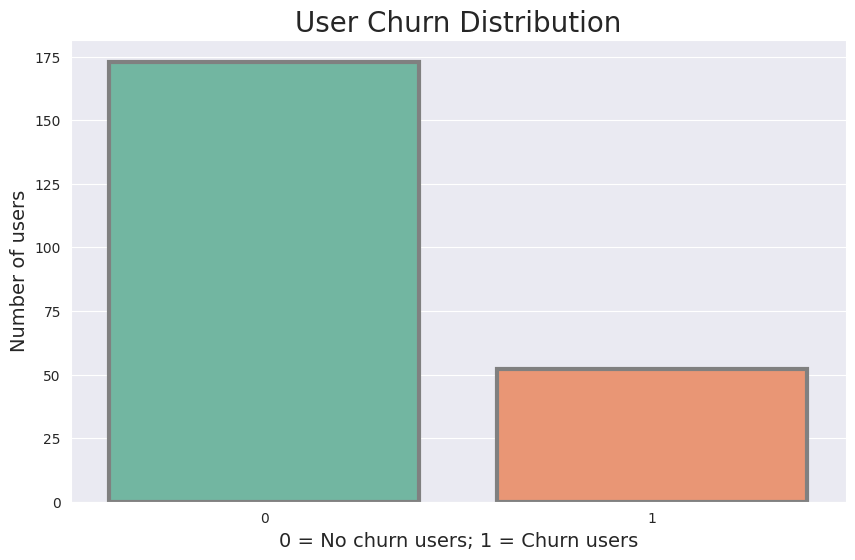

In [26]:
user_churn_distribution = eda_df.select(["userId", "churn"]).distinct().groupby("churn").count().toPandas()
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.barplot(data=user_churn_distribution, x="churn", y="count", errorbar=("pi", 50), capsize=.4, errcolor=".5", linewidth=3, edgecolor=".5", ax=ax)
ax.set_title("User Churn Distribution", fontsize=20)
ax.set_xlabel("0 = No churn users; 1 = Churn users", fontsize=14)
ax.set_ylabel("Number of users", fontsize=14)
fig.savefig("images/user_churn_distribution.jpg");

The distribution is highly skewed towards the `no churn` users. That is why we will use the `F1` score to find the best model in the cross validation step.

#### Possible Pages

In [27]:
eda_df.select("page").distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [28]:
eda_df.filter(F.col("artist") != "unknown").select("page").distinct().show()

+--------+
|    page|
+--------+
|NextSong|
+--------+



The only page where music is played is called `NextSong`.

#### Gender Distribution

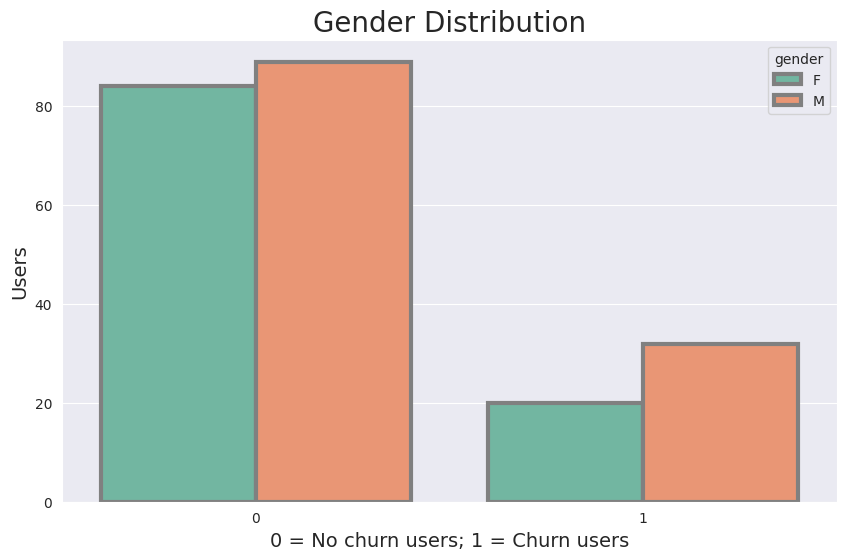

In [29]:
gender_distribution = eda_df.select(["churn", "userId", "gender"]).distinct().groupby(["churn", "gender"]).count().toPandas()
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.barplot(data=gender_distribution, x="churn", y="count", hue="gender", errorbar=("pi", 50), capsize=.4, errcolor=".5", linewidth=3, edgecolor=".5", ax=ax)
ax.set_title("Gender Distribution", fontsize=20)
ax.set_xlabel("0 = No churn users; 1 = Churn users", fontsize=14)
ax.set_ylabel("Users", fontsize=14)
fig.savefig("images/gender_distribution.jpg");

Visually it seems that more males are in the churn group than females. But, we won't use this as a feature because the difference is not that big (to be 100%, we should statistically check the difference between the two distributions), and we don't want to bias the model towards gender.

#### Distribution of the Average Number of Visited Pages by Every User

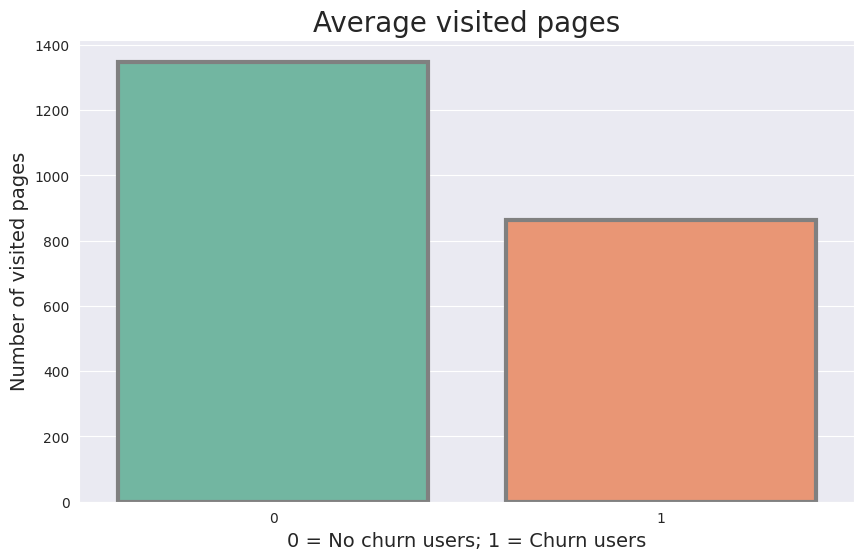

In [30]:
visited_pages_distribution = eda_df.groupby(["churn", "userId"]).count().groupby("churn").agg(F.avg("count").alias("Average Visited Pages")).toPandas()
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.barplot(data=visited_pages_distribution, x="churn", y="Average Visited Pages", errorbar=("pi", 50), capsize=.4, errcolor=".5", linewidth=3, edgecolor=".5", ax=ax)
ax.set_title("Average visited pages", fontsize=20)
ax.set_xlabel("0 = No churn users; 1 = Churn users", fontsize=14)
ax.set_ylabel("Number of visited pages", fontsize=14)
fig.savefig("images/visited_pages_distribution.jpg");

Users that remained on the platform, on average, visited more pages.

#### Distribution of the Average Number of Songs Listened by Every User

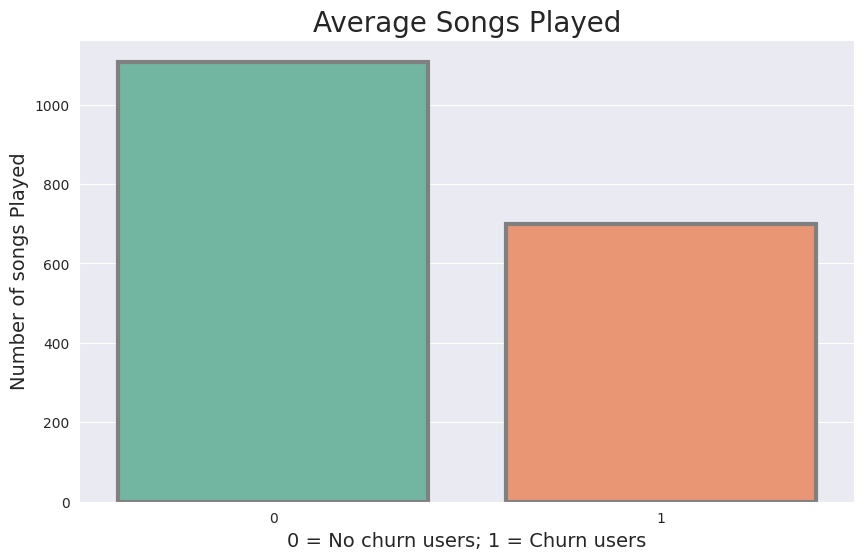

In [31]:
listened_songs_distribution = eda_df.where(F.col("artist") != "unknown").groupby(["churn", "userId"]).count().groupby("churn").agg(F.avg("count").alias("Average Songs Played")).toPandas()
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.barplot(data=listened_songs_distribution, x="churn", y="Average Songs Played", errorbar=("pi", 50), capsize=.4, errcolor=".5", linewidth=3, edgecolor=".5", ax=ax)
ax.set_title("Average Songs Played", fontsize=20)
ax.set_xlabel("0 = No churn users; 1 = Churn users", fontsize=14)
ax.set_ylabel("Number of songs Played", fontsize=14)
fig.savefig("images/listened_songs_distribution.jpg");

Users that remained on the platform, on average, are listening to more songs.

#### Distribution of the Average Number of Artists Listened by Every User

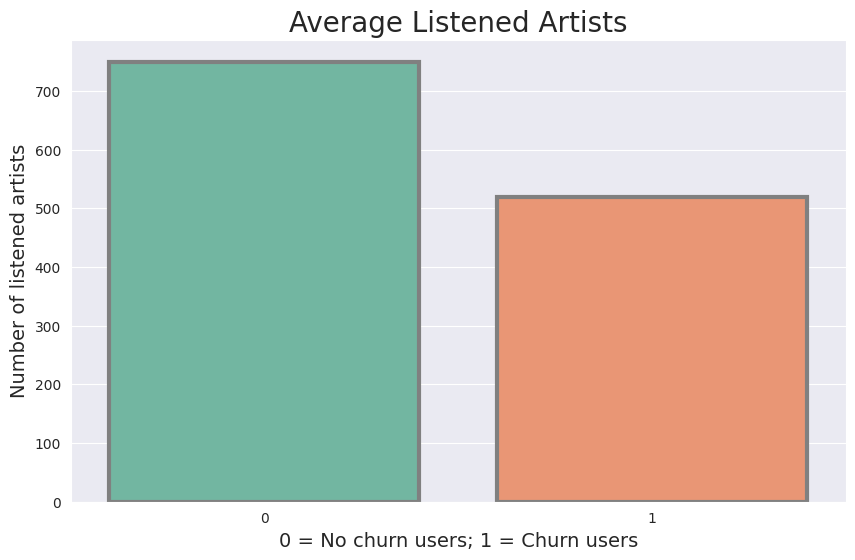

In [32]:
listened_artists_distribution = eda_df \
    .select(["artist", "userId", "churn"]) \
    .where(F.col("artist") != "unknown") \
    .distinct() \
    .groupby(["churn", "userId"]) \
    .count() \
    .groupby("churn") \
    .agg(F.avg("count").alias("Average Listened Artists")) \
    .toPandas()
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.barplot(data=listened_artists_distribution, x="churn", y="Average Listened Artists", errorbar=("pi", 50), capsize=.4, errcolor=".5", linewidth=3, edgecolor=".5", ax=ax)
ax.set_title("Average Listened Artists", fontsize=20)
ax.set_xlabel("0 = No churn users; 1 = Churn users", fontsize=14)
ax.set_ylabel("Number of listened artists", fontsize=14)
fig.savefig("images/listened_artists_distribution.jpg");

#### Average Seconds of Listened Music

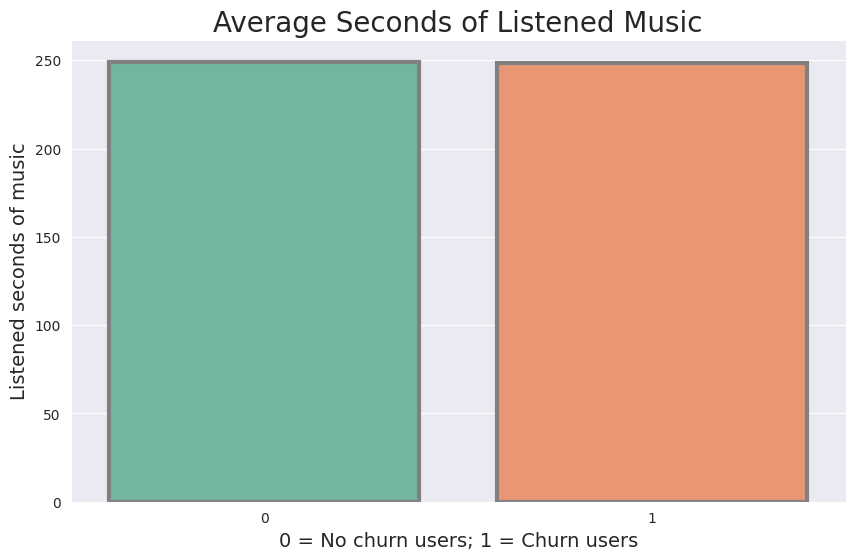

In [33]:
average_listened_seconds_distribution = eda_df \
    .select(["artist", "userId", "churn", "length"]) \
    .where(F.col("artist") != "unknown") \
    .groupby(["churn", "userId"]) \
    .agg(F.avg(F.col("length")).alias("averageLength")) \
    .groupby("churn") \
    .agg(F.avg(F.col("averageLength")).alias("Average Seconds of Listened Music")) \
    .toPandas()
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.barplot(data=average_listened_seconds_distribution, x="churn", y="Average Seconds of Listened Music", errorbar=("pi", 50), capsize=.4, errcolor=".5", linewidth=3, edgecolor=".5", ax=ax)
ax.set_title("Average Seconds of Listened Music", fontsize=20)
ax.set_xlabel("0 = No churn users; 1 = Churn users", fontsize=14)
ax.set_ylabel("Listened seconds of music", fontsize=14)
fig.savefig("images/average_listened_seconds_distribution.jpg");

The average seconds of listened music is similar for both churn and no-churn groups. Therefore, this feature won't have much predictive power.

# Feature Engineering

#### Aggregate Data at the User Level
The churn classification will be performed at the user level. Therefore, we need to aggregate the data for every user. All the features will be a result of this aggregation.

In [34]:
def count_with_condition(condition):
    """Utility function to count only specific rows based on the 'condition'."""
    return F.count(F.when(condition, True))


def count_distinct_with_condition(condition, values):
    """Utility function to count only distinct & specific rows based on the 'condition'."""
    return F.count_distinct(F.when(condition, values))

In [35]:
marked_df = labeled_df.withColumn("listeningToMusic", F.when(F.col("page") == "NextSong", 1).otherwise(0))

In [36]:
aggregated_df = labeled_df.groupby("userId").agg(
    F.count("page").alias("numPagesVisited"),
    count_with_condition(F.col("page") == "NextSong").alias("numTotalPlays"),
    count_distinct_with_condition(F.col("artist") != "unknown", F.col("artist")).alias("numTotalArtists"),
    F.max("churn").alias("churn")
)
aggregated_df.show()

+------+---------------+-------------+---------------+-----+
|userId|numPagesVisited|numTotalPlays|numTotalArtists|churn|
+------+---------------+-------------+---------------+-----+
|100010|            381|          275|            252|    0|
|100014|            310|          257|            233|    1|
|100021|            319|          230|            207|    1|
|   101|           2149|         1797|           1241|    1|
|    11|            848|          647|            534|    0|
|   112|            292|          215|            195|    0|
|   113|           1895|         1585|           1111|    0|
|   124|           4825|         4079|           2232|    0|
|   125|             11|            8|              8|    1|
|   132|           2304|         1928|           1299|    0|
|   133|             44|           32|             32|    0|
|   138|           2469|         2070|           1332|    0|
|   139|            457|          377|            334|    0|
|   146|            837|

#### Create the Feature Vector and Labels

In [37]:
assembler = VectorAssembler(inputCols=["numPagesVisited", "numTotalPlays", "numTotalArtists"], outputCol="unscaled_features")
engineered_df = assembler.transform(aggregated_df)
engineered_df = engineered_df.select(F.col("unscaled_features"), F.col("churn").alias("label"))
engineered_df.show()

+--------------------+-----+
|   unscaled_features|label|
+--------------------+-----+
| [381.0,275.0,252.0]|    0|
| [310.0,257.0,233.0]|    1|
| [319.0,230.0,207.0]|    1|
|[2149.0,1797.0,12...|    1|
| [848.0,647.0,534.0]|    0|
| [292.0,215.0,195.0]|    0|
|[1895.0,1585.0,11...|    0|
|[4825.0,4079.0,22...|    0|
|      [11.0,8.0,8.0]|    1|
|[2304.0,1928.0,12...|    0|
|    [44.0,32.0,32.0]|    0|
|[2469.0,2070.0,13...|    0|
| [457.0,377.0,334.0]|    0|
| [837.0,650.0,541.0]|    0|
|[2278.0,1914.0,13...|    0|
|   [118.0,84.0,78.0]|    0|
|[1002.0,820.0,643.0]|    0|
| [474.0,387.0,339.0]|    0|
| [317.0,237.0,214.0]|    0|
|[3603.0,3028.0,18...|    1|
+--------------------+-----+
only showing top 20 rows



# Modeling
We will use the `F1 score` to test the models because we will use a classifier, and the data labels are skewed towards the `no churn` users. A `churn` event is considered rarer. By using the `F1 score`, we think the `precision` and `recall` of the model assume the unbalanced distribution issue.

In [38]:
def run(pipeline, paramGrid, train_df, test_df):
    """
    Main function used to train & test a given model.
    The training step uses cross-validation to find the best hyper-parameters for the model.

    :param pipeline: Model pipeline.
    :param paramGrid: Parameter grid used for cross-validation.
    :param train_df: Training dataframe.
    :param test_df: Testing dataframe.
    :return: the best model from cross-validation.
    """

    fitted_model = fit_model(paramGrid, pipeline, train_df)
    evaluate_model(fitted_model, test_df)

    return fitted_model


def fit_model(paramGrid, pipeline, train_df):
    """
    Function that trains the model using cross-validation.
    Also, it prints the best validation results and hyper-parameters.

    :param paramGrid: Parameter grid used for cross-validation.
    :param pipeline: Model pipeline.
    :param train_df: Training dataframe.
    :return: the best model from cross-validation.
    """

    crossval = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=paramGrid,
        evaluator=MulticlassClassificationEvaluator(metricName="f1", beta=1.0),
        parallelism=3,
        numFolds=3
    )

    fitted_model = crossval.fit(train_df)
    print_best_validation_score(fitted_model)
    print_best_parameters(fitted_model)

    return fitted_model


def create_pipeline(model):
    """
    Create a pipeline based on a model.

    :param model: The end model that will be used for training.
    :return: the built pipeline.
    """

    scaler = StandardScaler(inputCol="unscaled_features", outputCol="features")
    pipeline = Pipeline(stages=[scaler, model])

    return pipeline


def print_best_validation_score(cross_validation_model):
    """Prints the best validation score based on the results from the cross-validation model."""
    print()
    print("-" * 60)
    print(f"F1 score, on the validation split, for the best model: {np.max(cross_validation_model.avgMetrics) * 100:.2f}%")
    print("-" * 60)


def print_best_parameters(cross_validation_model):
    """Prints the best hyper-parameters based on the results from the cross-validation model."""

    parameters = cross_validation_model.getEstimatorParamMaps()[np.argmax(cross_validation_model.avgMetrics)]

    print()
    print("-" * 60)
    print("Best model hyper-parameters:")
    for param, value in parameters.items():
        print(f"{param}: {value}")
    print("-" * 60)


def evaluate_model(model, test_df):
    """Evaluate the model on the test set using F1 score and print the results."""

    predictions = model.transform(test_df)
    evaluator =  MulticlassClassificationEvaluator(metricName="f1", beta=1.0)
    metric = evaluator.evaluate(predictions)

    print()
    print("-" * 60)
    print(f"F1 score, on the test set is: {metric*100:.2f}%")
    print("-" * 60)

    return metric

## Split the Data

In [39]:
train_df, test_df = engineered_df.randomSplit([0.8, 0.2], seed=42)

## Logistic Regression

In [40]:
lr = LogisticRegression()
pipeline = create_pipeline(lr)

paramGrid = ParamGridBuilder() \
    .addGrid(lr.maxIter, [10, 25, 50])  \
    .addGrid(lr.regParam, [0.05, 0.1, 0.2]) \
    .addGrid(lr.elasticNetParam, [0.05, 0.1, 0.2]) \
    .build()

In [41]:
run(pipeline, paramGrid, train_df.alias("train_df_lr"), test_df.alias("test_df_lr"))

22/09/17 14:34:38 WARN BlockManager: Asked to remove block broadcast_3571, which does not exist
22/09/17 14:34:38 WARN BlockManager: Asked to remove block broadcast_3571_piece0, which does not exist



------------------------------------------------------------
F1 score, on the validation split, for the best model: 67.28%
------------------------------------------------------------

------------------------------------------------------------
Best model hyper-parameters:
LogisticRegression_499269b0660a__maxIter: 10
LogisticRegression_499269b0660a__regParam: 0.05
LogisticRegression_499269b0660a__elasticNetParam: 0.05
------------------------------------------------------------

------------------------------------------------------------
F1 score, on the test set is: 62.94%
------------------------------------------------------------


CrossValidatorModel_357324f51e04

## Naive Bayes

In [42]:
nb = NaiveBayes()
pipeline = create_pipeline(nb)

paramGrid = ParamGridBuilder() \
    .addGrid(nb.smoothing, [0.5, 1, 2])  \
    .build()

In [43]:
run(pipeline, paramGrid, train_df.alias("train_df_nb"), test_df.alias("test_df_nb"))


------------------------------------------------------------
F1 score, on the validation split, for the best model: 67.28%
------------------------------------------------------------

------------------------------------------------------------
Best model hyper-parameters:
NaiveBayes_7fe0548e5280__smoothing: 0.5
------------------------------------------------------------

------------------------------------------------------------
F1 score, on the test set is: 62.94%
------------------------------------------------------------


CrossValidatorModel_43e24e7a6fe9

## Gradient Boosting

In [44]:
gbt = GBTClassifier()
pipeline = create_pipeline(gbt)

paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [10, 20, 30]) \
    .addGrid(gbt.stepSize, [0.05, 0.1]) \
    .build()

In [45]:
run(pipeline, paramGrid, train_df.alias("train_df_gbt"), test_df.alias("test_df_gbt"))

22/09/17 14:36:28 WARN BlockManager: Asked to remove block broadcast_6143_piece0, which does not exist
22/09/17 14:36:28 WARN BlockManager: Asked to remove block broadcast_6143, which does not exist
22/09/17 14:36:29 WARN BlockManager: Asked to remove block broadcast_6167, which does not exist
22/09/17 14:36:34 WARN BlockManager: Asked to remove block broadcast_6282, which does not exist
22/09/17 14:36:56 WARN BlockManager: Asked to remove block broadcast_6843, which does not exist
22/09/17 14:37:42 WARN BlockManager: Asked to remove block broadcast_7924, which does not exist
22/09/17 14:37:42 WARN BlockManager: Asked to remove block broadcast_7924_piece0, which does not exist
22/09/17 14:37:42 WARN BlockManager: Asked to remove block broadcast_7927, which does not exist
22/09/17 14:37:42 WARN BlockManager: Asked to remove block broadcast_7927_piece0, which does not exist



------------------------------------------------------------
F1 score, on the validation split, for the best model: 71.54%
------------------------------------------------------------

------------------------------------------------------------
Best model hyper-parameters:
GBTClassifier_66b5777c3488__maxIter: 20
GBTClassifier_66b5777c3488__stepSize: 0.1
------------------------------------------------------------

------------------------------------------------------------
F1 score, on the test set is: 64.92%
------------------------------------------------------------


CrossValidatorModel_7c04f8be8ffb

# Conclusion

After the cleaning & feature engineering steps, we trained three models:
* Logistic Regression
* Naive Bayes
* Gradient Boosting

The `GBT` model performed slightly better than the Logistic Regression and the Naive Bayes. Probably, because it is a more complex model that can understand non-linear relationships better. It has an `F1 score` of `64.92%`, which is not great. We could do better, but it is a good start to see that the model can pick up some patterns within the data.

To further improve the model, we can do the following:
* add more features
* solve the label imbalance
* use the `Downgrade` event to generate more `churn` labels